In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:0')


1.2.0


In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        classes = self.target_labels[idx][1]
        family =  self.target_labels[idx][0]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes, family

In [3]:
INPUT_CHANNEL = 3
BATCH_SIZE = 32
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imagenet_classes = range(1, 22)

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"
Train_data = Weedread(data_path + "train.h5", transform=normalize)
Test_data = Weedread(data_path + "val.h5", transform=normalize)

Train_dataloader = DataLoader(dataset=Train_data, batch_size = BATCH_SIZE, shuffle=True)
Test_dataloader = DataLoader(dataset=Test_data, batch_size = BATCH_SIZE, shuffle=False)

print(Train_data.__len__())
def get_iterator(mode):
    if mode is True:
        return Train_dataloader
    elif mode is False:
        return Test_dataloader

125498


In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class ResNet_baseline(nn.Module):
    def __init__(self, num_classes = 21):
        super(ResNet_baseline, self).__init__()
        model = models.resnet18(pretrained=False)
        self.model_ft = torch.nn.Sequential(*(list(model.children())[:-1]))
        set_parameter_requires_grad(self.model_ft, False)

        self.class_fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.model_ft(x)
        x = torch.flatten(x, 1)
        x_class = self.class_fc(x)
       
        return x_class

In [6]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [7]:
class CorssEntropyloss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CorssEntropyloss, self).__init__()
        self.alpha = alpha
        self.class_loss = nn.CrossEntropyLoss()
       
    def forward(self, predicted_class, true_class):
        return self.alpha * self.class_loss(predicted_class, true_class)

In [8]:
from torchsummary import summary
train_images, _, _ = next(iter(Test_dataloader))

_model = ResNet_baseline(num_classes = 21)
summary(_model, input_size= train_images[0].size(), device="cpu")
_model = _model.to(device)

_loss = LabelSmoothingLoss(classes = 21, smoothing = 0.1)
#_loss = CorssEntropyloss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [9]:
def main():
    #main processor
    def h(sample):
        data, classes, _, training = sample
        
        if(training):
            _model.train()
        else:
            _model.eval()
        labels = torch.LongTensor(classes).to(device)
        data = data.to(device).float()
        
        f_class = _model(data)
        loss = _loss(f_class, labels)
        
        p_class = F.softmax(f_class, dim=1)
        return loss, p_class
    
    #---------log--------------
    def plot_log(log):
        log = np.array(log)
        fig = plt.figure(figsize = (15, 8))
        #loss
        plt.plot(log[:,0]); plt.plot(log[:,2])
        plt.title("Loss per epoch"); plt.xlabel("epochs"); plt.ylabel("error")
        plt.legend(["training loss", "validation loss"])
        plt.show()
        fig = plt.figure(figsize = (15, 8))
        #accuracy
        max_value = np.round(np.max(log[:, 3]), decimals=4)
        max_index = np.argmax(log[:, 3])
        plt.plot(log[:,1]); plt.plot(log[:,3])
        plt.text(max_index, max_value, str(max_value), fontsize=10)
        plt.title("Accuracy per epoch"); plt.xlabel("epochs"); plt.ylabel("ACC")
        plt.legend(["training accuracy", "validation accuracy"])
        plt.show()
        
    log = []
    engine = Engine()
    EPOCHS = 100
    optimizer = torch.optim.Adam(_model.parameters(), lr=0.001)
    meter_loss = tnt.meter.AverageValueMeter()
    classerr = tnt.meter.ClassErrorMeter(accuracy=True)
    
    def reset_meters():
        classerr.reset()
        meter_loss.reset()

    def on_sample(state):
        state['sample'].append(state['train'])

    def on_forward(state):
        classerr.add(state['output'].data, torch.LongTensor(state['sample'][1]))
        meter_loss.add(state['loss'].item())

    def on_start_epoch(state):
        reset_meters()
        state['iterator'] = tqdm(state['iterator'], desc="[Epoch %d / %d]"%(state['epoch'] + 1, EPOCHS))

    def on_end_epoch(state):
        log.append([])
        display.clear_output(wait=True)
        print('Training loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        # do validation at the end of each epoch
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        reset_meters()
        engine.test(h, get_iterator(False))
        print('Testing loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        if(classerr.value()[-1] == np.max(np.array(log)[:, 3])):
            torch.save(_model.state_dict(), 'epochs/ResNet-labelsmoothing.pt')
        
        plot_log(log)
        plt.pause(0.005)
        
    engine.hooks['on_sample'] = on_sample
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch
    engine.train(h, get_iterator(True), maxepoch=EPOCHS, optimizer=optimizer)

Training loss: 0.6317, accuracy: 99.6972%
Testing loss: 0.7565, accuracy: 95.7788%


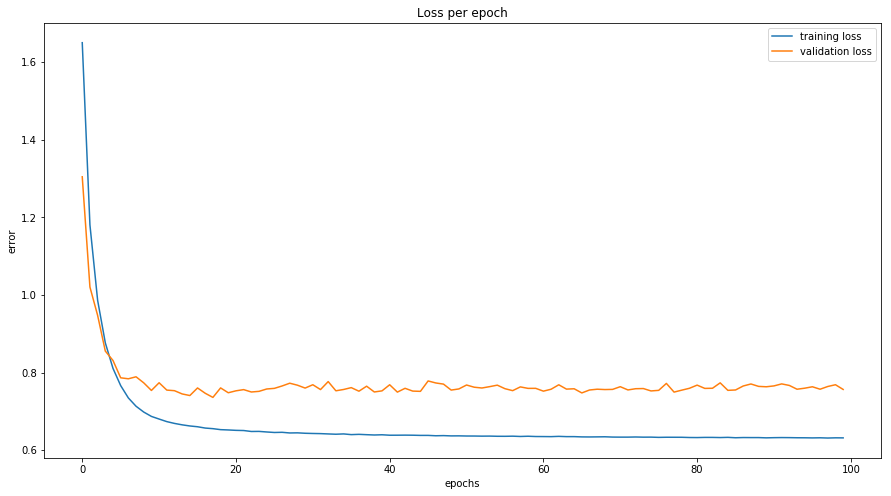

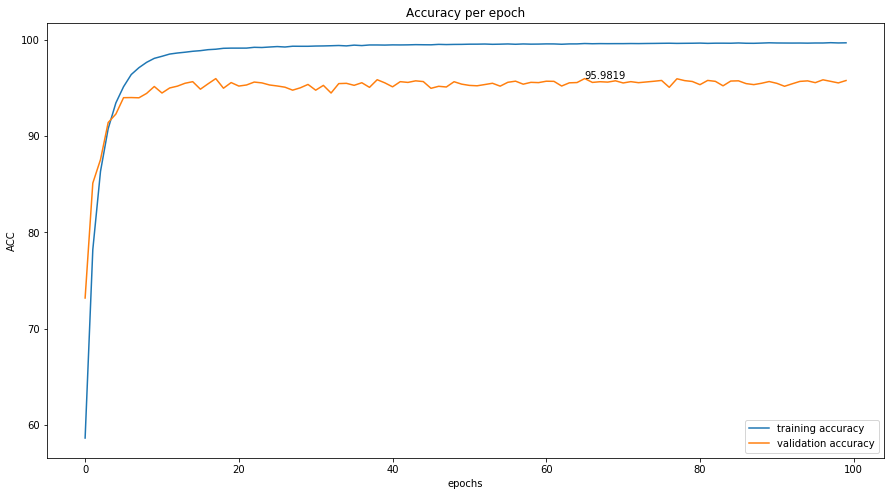

In [10]:
main()